# Suitability Filter Experiments

In [11]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from examples.models.initializer import (
    initialize_bert_based_model,
    initialize_torchvision_model,
)
from examples.transforms import initialize_transform
from torch.utils.data import DataLoader, random_split

import suitability.filter.tests as ftests
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter import suitability
from wilds import get_dataset

importlib.reload(suitability)

from suitability.filter.suitability import SuitabilityFilter

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

random.seed(32)
np.random.seed(32)

## Define data and model

In [6]:
def remove_prefix_from_state_dict(state_dict, prefix="model."):
    """
    Remove the prefix from the keys in state_dict if it exists.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix) :]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [7]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "fmow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

test_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Asia"},
)
regressor_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Americas"},
)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Initialize suitability filter

In [ ]:
suitability_filter = SuitabilityFilter(model, test_data, regressor_data, device, use_labels=True)
test_features, test_corr = suitability_filter.get_features(test_data)
suitability_filter.train_regressor(calibrated=True)

## Evaluate the suitability filter

### In-the-wild evaluation and comparison to AC

In [29]:
REGIONS = ["Asia", "Europe", "Africa", "Americas", "Oceania"]

# Construct suitability filter
features = {}
correctness = {}
acs = {}

for region in REGIONS:
    user_data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"region": region},
    )

    user_features, user_corr = suitability_filter.get_features(user_data)
    acs[region] = np.mean(user_features, axis=0)[1]
    correctness[region] = user_corr
    test = suitability_filter.suitability_test(user_features=user_features, margin=0, test_power=True)

    print(f"--- Region {region}: {user_features.shape[0]} samples ---")
    print(
        f"{np.mean(user_corr) * 100:.2f}% correct (compared to {np.mean(test_corr) * 100:.2f}% for test)"
    )
    print(
        f"AC: {acs[region]:.4f}, test AC: {np.mean(test_features, axis=0)[1]:.4f} -> {'SUITABLE' if acs[region] >= np.mean(test_features, axis=0)[1] else 'NOT SUITABLE'}"
    )
    print(
        f"Non-inferiority-test, p-value {test['p_value']:.4f} -> {'SUITABLE' if test['p_value']<=0.05 else 'NOT SUITABLE'}",
    )
    print(test)

--- Region Asia: 4963 samples ---
55.35% correct (compared to 56.10% for test)
AC: 0.8885, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 0.5705 -> NOT SUITABLE
{'t_statistic': 0.17765594431928577, 'p_value': 0.5705013538940319, 'reject_null': False, 'power': 0.03418418192567085}
--- Region Europe: 5858 samples ---
56.16% correct (compared to 56.10% for test)
AC: 0.8914, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 0.0040 -> SUITABLE
{'t_statistic': -2.653638923029464, 'p_value': 0.003988387013338177, 'reject_null': True, 'power': 0.8390978334890897}
--- Region Africa: 2593 samples ---
32.78% correct (compared to 56.10% for test)
AC: 0.8448, test AC: 0.8858 -> NOT SUITABLE
Non-inferiority-test, p-value 1.0000 -> NOT SUITABLE
{'t_statistic': 15.547128133928977, 'p_value': 1.0, 'reject_null': False, 'power': 0.0}
--- Region Americas: 8024 samples ---
56.72% correct (compared to 56.10% for test)
AC: 0.8979, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 

### SHAP analysis for signals

  0%|          | 0/6562 [00:00<?, ?it/s]

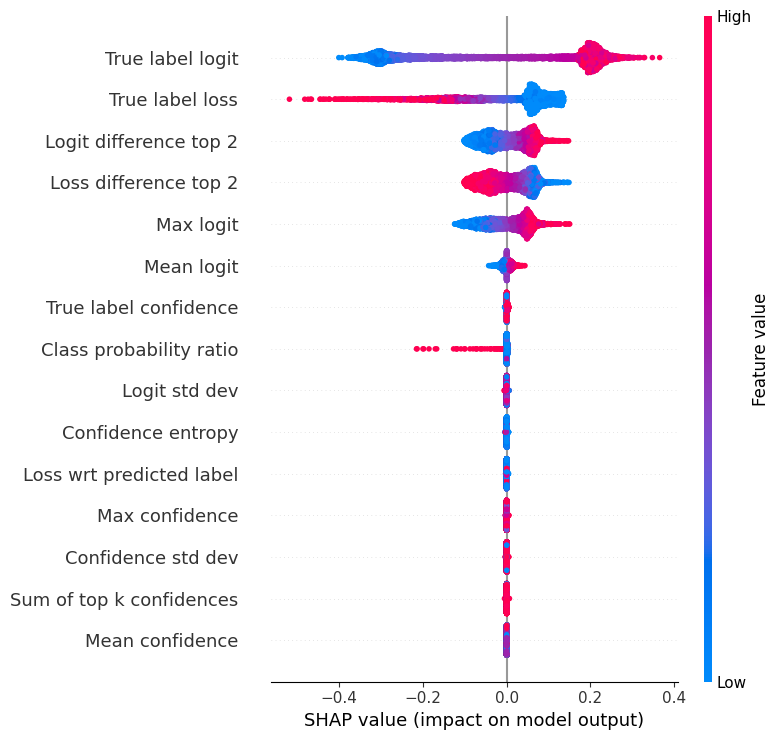

In [10]:
# Calculate SHAP values
shap_values, explainer = suitability_filter.calculate_shap_values()

# To visualize
feature_names = [
    "Mean confidence",
    "Max confidence",
    "Confidence std dev",
    "Confidence entropy",
    "Mean logit",
    "Max logit",
    "Logit std dev",
    "Logit difference top 2",
    "Loss wrt predicted label",
    "Loss difference top 2",
    "Class probability ratio",
    "Sum of top k confidences",
    "True label confidence",
    "True label logit",
    "True label loss",
]

shap.summary_plot(shap_values[:, :, 1], suitability_filter.regressor_features, feature_names=feature_names)

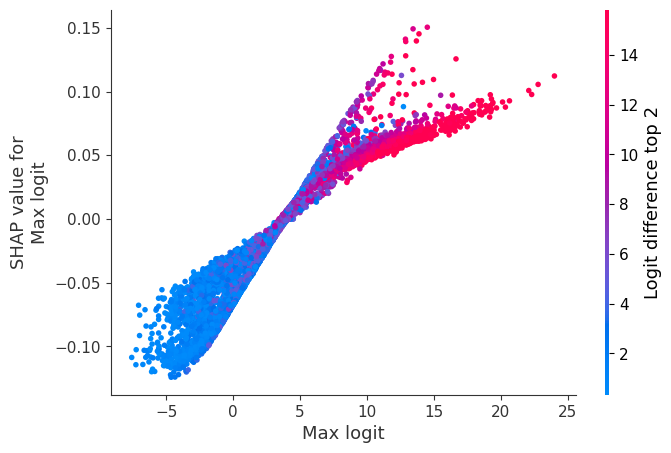

In [11]:
shap.dependence_plot("Max logit", shap_values[:, :, 1], suitability_filter.regressor_features, feature_names=feature_names, interaction_index="Logit difference top 2")

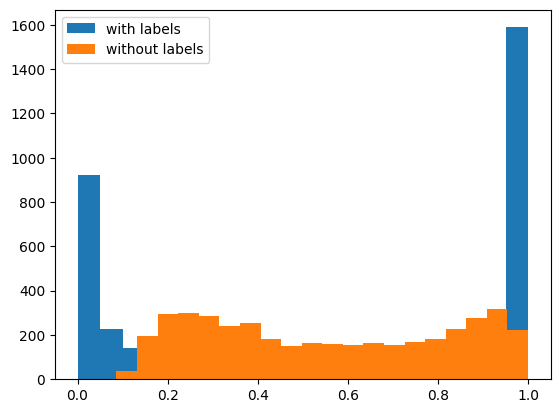

In [24]:
plt.hist(regressor_labels.predict_proba(test_features_labels)[:,1], label="with labels", bins=20)
plt.hist(regressor_no_labels.predict_proba(test_features)[:,1], label="without labels", bins=20)
plt.legend()
plt.show()

### ANOVA analysis

In [6]:
from sklearn.feature_selection import f_classif

F_values, p_values = f_classif(suitability_filter.regressor_features, suitability_filter.regressor_correct)
feature_names = [
    "Mean confidence",
    "Max confidence",
    "Confidence std dev",
    "Confidence entropy",
    "Mean logit",
    "Max logit",
    "Logit std dev",
    "Logit difference top 2",
    "Loss wrt predicted label",
    "Loss difference top 2",
    "Class probability ratio",
    "Sum of top k confidences"
]

for i, (f_val, p_val) in enumerate(zip(F_values, p_values)):
    print(f"Feature {feature_names[i]}: F-value = {f_val:.2f}, p-value = {p_val}")

Feature Mean confidence: F-value = 0.00, p-value = 1.0
Feature Max confidence: F-value = 1319.74, p-value = 0.0
Feature Confidence std dev: F-value = 1430.76, p-value = 0.0
Feature Confidence entropy: F-value = 1571.25, p-value = 0.0
Feature Mean logit: F-value = 1253.05, p-value = 0.0
Feature Max logit: F-value = 2545.48, p-value = 0.0
Feature Logit std dev: F-value = 223.74, p-value = 0.0
Feature Logit difference top 2: F-value = 2354.75, p-value = 0.0
Feature Loss wrt predicted label: F-value = 1121.59, p-value = 0.0
Feature Loss difference top 2: F-value = 2364.70, p-value = 0.0
Feature Class probability ratio: F-value = 22.24, p-value = 2.4545795440644724e-06
Feature Sum of top k confidences: F-value = 327.24, p-value = 0.0


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(suitability_filter.regressor_features)
y_train = suitability_filter.regressor_correct

F_values, p_values = f_classif(X_train, y_train)
feature_names = [
    "Mean confidence",
    "Max confidence",
    "Confidence std dev",
    "Confidence entropy",
    "Mean logit",
    "Max logit",
    "Logit std dev",
    "Logit difference top 2",
    "Loss wrt predicted label",
    "Loss difference top 2",
    "Class probability ratio",
    "Sum of top k confidences"
]

for i, (f_val, p_val) in enumerate(zip(F_values, p_values)):
    print(f"Feature {feature_names[i]}: F-value = {f_val:.2f}, p-value = {p_val}")

Feature Mean confidence: F-value = 5.20, p-value = 0.022608259692788124
Feature Max confidence: F-value = 1319.48, p-value = 0.0
Feature Confidence std dev: F-value = 1429.45, p-value = 0.0
Feature Confidence entropy: F-value = 1571.25, p-value = 0.0
Feature Mean logit: F-value = 1253.08, p-value = 0.0
Feature Max logit: F-value = 2545.47, p-value = 0.0
Feature Logit std dev: F-value = 223.70, p-value = 0.0
Feature Logit difference top 2: F-value = 2354.74, p-value = 0.0
Feature Loss wrt predicted label: F-value = 1121.58, p-value = 0.0
Feature Loss difference top 2: F-value = 2364.69, p-value = 0.0
Feature Class probability ratio: F-value = 22.24, p-value = 2.454499281157041e-06
Feature Sum of top k confidences: F-value = 324.71, p-value = 0.0


## Experiments on civilcomments

In [25]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "civilcomments"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    pass

config = Config()
config.model = "distilbert-base-uncased"
config.max_token_length = 300
config.pretrained_model_path = None
config.model_kwargs = {}

model = initialize_bert_based_model(config, d_out=2)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

dataset = get_dataset(dataset=dataset_name, download=False, root_dir="/mfsnic/u/apouget/data/")
eval_transform = initialize_transform(
        transform_name="bert",
        config=config,
        dataset=dataset,
        is_training=False)

data = dataset.get_subset(
    "val",
    transform=eval_transform,
)

test, regressor = random_split(data, [0.5, 0.5])
test_data = DataLoader(test, batch_size=64, shuffle=False, num_workers=4)
regressor_data = DataLoader(regressor, batch_size=64, shuffle=False, num_workers=4)

Some weights of DistilBertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
test_data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"sensitive": "other_religions"},
    )

suitability_filter = SuitabilityFilter(model, test_data, regressor_data, device, use_labels=False)
test_features, test_corr = suitability_filter.get_features(test_data)
suitability_filter.train_regressor(calibrated=False)

print(len(test_corr))

3500


In [29]:
SENSITIVE = ["male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]

# Construct suitability filter
features = {}
correctness = {}
acs = {}

for sa in SENSITIVE:
    user_data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"sensitive": sa},
    )

    user_features, user_corr = suitability_filter.get_features(user_data)
    acs[sa] = np.mean(user_features, axis=0)[1]
    correctness[sa] = user_corr
    test = suitability_filter.suitability_test(user_features=user_features, margin=0, test_power=False)

    print(f"--- Sensitive attribute {sa}: {user_features.shape[0]} samples ---")
    print(
        f"{np.mean(user_corr) * 100:.2f}% correct (compared to {np.mean(test_corr) * 100:.2f}% for test)"
    )
    print(
        f"AC: {acs[sa]:.4f}, test AC: {np.mean(test_features, axis=0)[1]:.4f} -> {'SUITABLE' if acs[sa] >= np.mean(test_features, axis=0)[1] else 'NOT SUITABLE'}"
    )
    print(
        f"Non-inferiority-test, p-value {test['p_value']:.4f} -> {'SUITABLE' if test['p_value']<=0.05 else 'NOT SUITABLE'}",
    )
    print(test)

--- Sensitive attribute male: 14295 samples ---
88.92% correct (compared to 88.34% for test)
AC: 0.9825, test AC: 0.9812 -> SUITABLE
Non-inferiority-test, p-value 0.0000 -> SUITABLE
{'t_statistic': -6.302885566093372, 'p_value': 1.5771764180850104e-10, 'reject_null': True}
--- Sensitive attribute female: 16449 samples ---
89.94% correct (compared to 88.34% for test)
AC: 0.9846, test AC: 0.9812 -> SUITABLE
Non-inferiority-test, p-value 0.0000 -> SUITABLE
{'t_statistic': -9.35482989315053, 'p_value': 6.16026151252594e-21, 'reject_null': True}
--- Sensitive attribute LGBTQ: 4426 samples ---
79.62% correct (compared to 88.34% for test)
AC: 0.9667, test AC: 0.9812 -> NOT SUITABLE
Non-inferiority-test, p-value 1.0000 -> NOT SUITABLE
{'t_statistic': 20.855310330521085, 'p_value': 1.0, 'reject_null': False}
--- Sensitive attribute christian: 13361 samples ---
92.14% correct (compared to 88.34% for test)
AC: 0.9884, test AC: 0.9812 -> SUITABLE
Non-inferiority-test, p-value 0.0000 -> SUITABLE
{'